# ip data

In [5]:
from sklearn.utils import shuffle
import pandas as pd

def toint(row):
    row['1st Octet']=int(row['1st Octet'])
    row['2nd Octet']=int(row['2nd Octet'])
    row['3rd Octet']=int(row['3rd Octet'])
    row['4th Octet']=int(row['4th Octet'])
    return row
    
gooddata=pd.read_parquet('/stuff/parsed data/goodoctetdata')
baddata=pd.read_parquet('/stuff/parsed data/badoctetdata')


bcolumn=[1]*len(gooddata)
gooddata.insert(0,"Benign",bcolumn)

mcolumn=[0]*len(baddata)
baddata.insert(0,"Benign",mcolumn)

combineddata=gooddata.append(baddata,ignore_index=True)

shuffdata=shuffle(combineddata)
dedupdata=shuffdata.drop_duplicates(subset=["1st Octet","2nd Octet","3rd Octet","4th Octet"])



dedupdata=dedupdata.apply(toint,axis="columns")

traingood=dedupdata[dedupdata['Benign']==1].sample(20000)
trainbad=dedupdata[dedupdata['Benign']==0].sample(20000)

train=shuffle(traingood.append(trainbad))

test=dedupdata.loc[dedupdata.index.difference(train.index)]

#go straight to onehotencoder

In [4]:
dedupdata.duplicated(subset=["1st Octet","2nd Octet","3rd Octet","4th Octet"]).value_counts()

False    203175
dtype: int64

# ip data and binary data

In [11]:
from sklearn.utils import shuffle
import pandas as pd

def toint(row):
    row['1st Octet']=int(row['1st Octet'])
    row['2nd Octet']=int(row['2nd Octet'])
    row['3rd Octet']=int(row['3rd Octet'])
    row['4th Octet']=int(row['4th Octet'])
    return row

def ttlcleanup(row):
    ttlrow=[]
    for address in row['A']:
        try:
            tempdata=address.split('IN A')
            tempdata2=tempdata[0].split(' ')
            ttlrow.append(tempdata2[1])
        except IndexError:
            pass
    return ttlrow

def ipcleanup(row):
    iprow=[]
    for address in row['A']:
        try:
            tempstring=address.split('IN A')
            iprow.append(tempstring[1].strip())
        except IndexError:  
            pass
    return iprow

def binarizer(cell):
    if cell[0]=="No Answer" or cell[0]=="Timeout":
        return 0
    else:
        return 1

goodcomplete=pd.read_parquet('/stuff/parsed data/gooddnsdata')
badcomplete=pd.read_parquet('/stuff/parsed data/baddnsdata')
    
bccolumn=[1]*len(goodcomplete)
mccolumn=[0]*len(badcomplete)

goodcomplete.insert(0,'Benign',bccolumn)
badcomplete.insert(0,'Benign',mccolumn)
##############################################################################
goodcomplete['ttl']=goodcomplete.apply(ttlcleanup,axis="columns")
badcomplete['ttl']=badcomplete.apply(ttlcleanup,axis="columns")


goodcomplete['A']=goodcomplete.apply(ipcleanup,axis="columns")
badcomplete['A']=badcomplete.apply(ipcleanup,axis="columns")


complete = goodcomplete.append(badcomplete,ignore_index=True)
#cut out rows with empty ip
complete=complete[complete['A'].map(lambda x: len(x)>0)]

#turn indicators into proper strings
complete['indicator']=complete['indicator'].apply(lambda x:x[0])

#reorder
complete=complete[['indicator','Benign','ttl', 'A', 'AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX','RP', 'SIG', 'SSHFP' ]]

#why not
reduced=complete.copy(deep=True)

#choose only first ip when multiple are returned, turn list into string
reduced['A']=reduced['A'].apply(lambda x: x[0])
reduced=reduced.drop_duplicates(subset="A")

#expand ip column
new=reduced['A'].str.split(".",expand=True)
reduced['1st Octet']=new[0]
reduced['2nd Octet']=new[1]
reduced['3rd Octet']=new[2]
reduced['4th Octet']=new[3]
reduced=reduced.drop(['A'],axis="columns")
reduced=reduced[['indicator', 'Benign','1st Octet', '2nd Octet', '3rd Octet',
'4th Octet' ,'AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX',
       'RP', 'SIG', 'SSHFP']]
reduced=shuffle(reduced)

#binarize the other records
reduced.loc[:,"AAAA":"SSHFP"]=reduced.loc[:,"AAAA":"SSHFP"].applymap(binarizer)

#test train split
traingood=reduced[reduced['Benign']==1].sample(20000)
trainbad=reduced[reduced['Benign']==0].sample(20000)

train=shuffle(traingood.append(trainbad))
train[['1st Octet', '2nd Octet', '3rd Octet',
       '4th Octet']]=train[['1st Octet', '2nd Octet', '3rd Octet',
       '4th Octet']].apply(toint,axis="columns")

test=shuffle(reduced.loc[reduced.index.difference(train.index)].sample(14000))

test[['1st Octet', '2nd Octet', '3rd Octet',
       '4th Octet']]=test[['1st Octet', '2nd Octet', '3rd Octet',
       '4th Octet']].apply(toint,axis="columns")


#go to one hot

In [12]:
from sklearn.preprocessing import OneHotEncoder


test.reset_index(inplace=True)

cats=[list(range(0,256)),list(range(0,256)),list(range(0,256)),list(range(0,256)),[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]
cats2=[list(range(0,256)),list(range(0,256)),list(range(0,256)),list(range(0,256))]
cats3=[[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]

#both
encoder=OneHotEncoder(categories=cats)
encodedtrain=encoder.fit_transform(train[["1st Octet","2nd Octet","3rd Octet","4th Octet",'AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX', 'RP', 'SIG',
      'SSHFP']])
encodedtest=encoder.fit_transform(test[["1st Octet","2nd Octet","3rd Octet","4th Octet",'AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX', 'RP', 'SIG',
      'SSHFP']])

#just ip data
encoder2=OneHotEncoder(categories=cats2)
encodedtrain2=encoder2.fit_transform(train[["1st Octet","2nd Octet","3rd Octet","4th Octet"]])
encodedtest2=encoder2.fit_transform(test[["1st Octet","2nd Octet","3rd Octet","4th Octet"]])

                                           
#just binary record data
encoder3=OneHotEncoder(categories=cats3)
encodedtrain3=encoder3.fit_transform(train[['AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX', 'RP', 'SIG',
      'SSHFP']])
encodedtest3=encoder3.fit_transform(test[['AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX', 'RP', 'SIG',
      'SSHFP']])


# Logistic Regression

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
glm=LogisticRegression()

model=glm.fit(encodedtrain,train['Benign'])
ypred=model.predict(encodedtest)
yprob=model.predict_proba(encodedtest)
print("ipdata and dnsdata")
print(classification_report(test['Benign'],ypred))

print("just ip data")
model2=glm.fit(encodedtrain2,train['Benign'])
ypred2=model.predict(encodedtest2)
yprob2=model.predict_proba(encodedtest2)
print(classification_report(test['Benign'],ypred2))


print("just dnsdata")
model3=glm.fit(encodedtrain3,train['Benign'])
ypred3=model.predict(encodedtest3)
yprob3=model.predict_proba(encodedtest3)
print(classification_report(test['Benign'],ypred3))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ipdata and dnsdata
              precision    recall  f1-score   support

           0       0.24      0.70      0.36      1148
           1       0.97      0.80      0.88     12852

   micro avg       0.79      0.79      0.79     14000
   macro avg       0.60      0.75      0.62     14000
weighted avg       0.91      0.79      0.83     14000

just ip data
              precision    recall  f1-score   support

           0       0.14      0.66      0.23      1148
           1       0.95      0.63      0.76     12852

   micro avg       0.64      0.64      0.64     14000
   macro avg       0.55      0.65      0.50     14000
weighted avg       0.89      0.64      0.72     14000

just dnsdata
              precision    recall  f1-score   support

           0       0.23      0.63      0.34      1148
           1       0.96      0.81      0.88     12852

   micro avg       0.80      0.80      0.80     14000
   macro avg       0.60      0.72      0.61     14000
weighted avg       0.90      

In [19]:
train['Benign'].value_counts()

1    20000
0    20000
Name: Benign, dtype: int64

# MLP 

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

clf=MLPClassifier(alpha=1e-10,max_iter= 200000, warm_start = False, shuffle=True)

model=clf.fit(encodedtrain,train['Benign'])
ypred=model.predict(encodedtest)
yprob=model.predict_proba(encodedtest)
print("ipdata and dnsdata")
print(classification_report(test['Benign'],ypred))

print("just ip data")
model2=clf.fit(encodedtrain2,train['Benign'])
ypred2=model.predict(encodedtest2)
yprob2=model.predict_proba(encodedtest2)
print(classification_report(test['Benign'],ypred2))


print("just dnsdata")
model3=clf.fit(encodedtrain3,train['Benign'])
ypred3=model.predict(encodedtest3)
yprob3=model.predict_proba(encodedtest3)
print(classification_report(test['Benign'],ypred3))

ipdata and dnsdata
              precision    recall  f1-score   support

           0       0.21      0.76      0.33      1148
           1       0.97      0.75      0.84     12852

   micro avg       0.75      0.75      0.75     14000
   macro avg       0.59      0.75      0.59     14000
weighted avg       0.91      0.75      0.80     14000

just ip data
              precision    recall  f1-score   support

           0       0.16      0.69      0.26      1148
           1       0.96      0.68      0.79     12852

   micro avg       0.68      0.68      0.68     14000
   macro avg       0.56      0.68      0.53     14000
weighted avg       0.89      0.68      0.75     14000

just dnsdata
              precision    recall  f1-score   support

           0       0.30      0.60      0.40      1148
           1       0.96      0.87      0.92     12852

   micro avg       0.85      0.85      0.85     14000
   macro avg       0.63      0.74      0.66     14000
weighted avg       0.91      

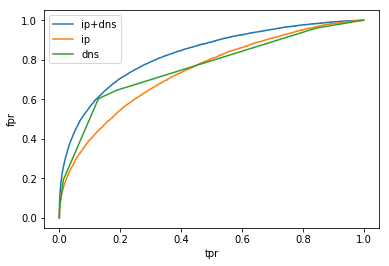

In [20]:
import matplotlib.pyplot as plt
fpr,tpr,thresholds=roc_curve(test['Benign'],yprob[:,0],pos_label=0)
fpr2,tpr2,thresholds2=roc_curve(test['Benign'],yprob2[:,0],pos_label=0)
fpr3,tpr3,thresholds3=roc_curve(test['Benign'],yprob3[:,0],pos_label=0)

plt.plot(fpr,tpr,fpr2,tpr2,fpr3,tpr3)

plt.xlabel("tpr")
plt.ylabel("fpr")
plt.legend(["ip+dns","ip","dns"])
plt.show()



# RANDOM FOREST

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rfc=RandomForestClassifier(n_estimators=300)

model=rfc.fit(encodedtrain,train['Benign'])
ypred=model.predict(encodedtest)
yprob=model.predict_proba(encodedtest)
print("ipdata and dnsdata")
print(classification_report(test['Benign'],ypred))

print("just ip data")
model2=rfc.fit(encodedtrain2,train['Benign'])
ypred2=model.predict(encodedtest2)
yprob2=model.predict_proba(encodedtest2)
print(classification_report(test['Benign'],ypred2))


print("just dnsdata")
model3=rfc.fit(encodedtrain3,train['Benign'])
ypred3=model.predict(encodedtest3)
yprob3=model.predict_proba(encodedtest3)
print(classification_report(test['Benign'],ypred3))



ipdata and dnsdata
              precision    recall  f1-score   support

           0       0.27      0.77      0.40      1148
           1       0.98      0.81      0.89     12852

   micro avg       0.81      0.81      0.81     14000
   macro avg       0.62      0.79      0.64     14000
weighted avg       0.92      0.81      0.85     14000

just ip data
              precision    recall  f1-score   support

           0       0.18      0.74      0.28      1148
           1       0.97      0.69      0.81     12852

   micro avg       0.70      0.70      0.70     14000
   macro avg       0.57      0.72      0.55     14000
weighted avg       0.90      0.70      0.76     14000

just dnsdata
              precision    recall  f1-score   support

           0       0.30      0.60      0.40      1148
           1       0.96      0.87      0.92     12852

   micro avg       0.85      0.85      0.85     14000
   macro avg       0.63      0.74      0.66     14000
weighted avg       0.91      

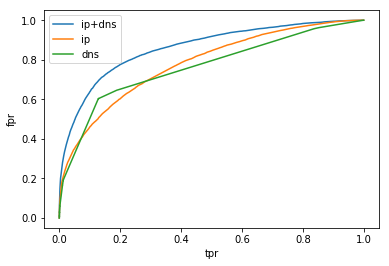

In [22]:
import matplotlib.pyplot as plt
fpr,tpr,thresholds=roc_curve(test['Benign'],yprob[:,0],pos_label=0)
fpr2,tpr2,thresholds2=roc_curve(test['Benign'],yprob2[:,0],pos_label=0)
fpr3,tpr3,thresholds3=roc_curve(test['Benign'],yprob3[:,0],pos_label=0)

plt.plot(fpr,tpr,fpr2,tpr2,fpr3,tpr3)

plt.xlabel("tpr")
plt.ylabel("fpr")
plt.legend(["ip+dns","ip","dns"])
plt.show()


# QDA

In [13]:
from sklearn.svm import SVC
supportvec=SVC()
model=supportvec.fit(encodedtrain,train['Benign'])
ypred=model.predict(encodedtest)
print(classification_report(test['Benign'],ypred))


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.29      0.61      0.40      9932
           1       0.96      0.87      0.91    112114

   micro avg       0.85      0.85      0.85    122046
   macro avg       0.63      0.74      0.66    122046
weighted avg       0.91      0.85      0.87    122046



# NEAREST NEIGHBOR

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier()
model=knn.fit(encodedtrain,train['Benign'])
ypred=model.predict(encodedtest)
print(classification_report(test['Benign'],ypred))


              precision    recall  f1-score   support

           0       0.09      0.91      0.17      9932
           1       0.97      0.23      0.37    112114

   micro avg       0.28      0.28      0.28    122046
   macro avg       0.53      0.57      0.27    122046
weighted avg       0.90      0.28      0.35    122046

